$$CONCEITO:$$

- **Modelo GLM derivam do modelo GLMM, portanto qualquer modelo GLM pode ser implantado no GLMM caso tenha níveis**


- **GLMM Captura o comportamento Heterocedastico(Efeitos Aleatórios) e Multicolineares(Efeitos Fixos) das variáveis**


- **Caso não tenho grupos definidos para analise multinível, pode fazer uma análise de cluster para encontrar os grupos**


- **Variáveis dummies só mudam o intercepto, não leva em consideração a inclinação da reta**



**Estratégia Step-Up:**


- **Não existe Step-wise para extrair parâmetros nos modelos Multiníveis, temos que fazer o passo a passo (Step-Up), inserindo estágios de efeitos aleatórios a cada modelagem:**


- **1° Modelo nulo** = Analisa se há efeito aleatório no intercepto, nível 1 variável target, nível 2 e 3 variáveis que podem dar aleatoriedade no intercepto


- **2° Modelo com Interceptos aleatórios** = Sabendo que existe efeitos aleatórios no intercepto (Nível 2 e 3), adicionamos variáveis no nível 1 para saber se existe efeitos aleatórios de inclinação no nível 2 e 3


- **3° Modelos com Interceptos e Inclinações aleatórias** = Agora que já sabemos que existe aleatoriedade tanto no intercepto quanto na inclinação, adicionamos variável/s de efeito aleatório de inclinação no nível 2 e 3


- **4° Demais Modelos** = Ir adicionando variáveis nos níveis e verificar se são estatisticamente significantes para a modelagem


In [1]:
#Pacotes
import multilevel_py
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Banco de dados 

In [2]:
# Carregando o dataset
dados = pd.read_csv('tempo_estudante_escola.csv',encoding='latin1',sep=',')
x = dados[['escola','mes','ativ','texp']]
y = dados.desempenho
dados

,escola,estudante,mes,desempenho,ativ,texp
0,1,1,1,35.400002,não,2
1,1,1,2,44.400002,não,2
2,1,1,3,46.400002,não,2
3,1,1,4,52.400002,não,2
4,1,2,1,74.900002,não,2
...,...,...,...,...,...,...
2435,15,609,4,100.000000,sim,9
2436,15,610,1,87.599998,sim,9
2437,15,610,2,92.599998,sim,9
2438,15,610,3,94.599998,sim,9


**Tabela com 2440 observações e 6 variáveis**

# Dicionário de Dados das variáveis Selecionadas

$$Variáveis:$$

- **estudante:** Número de estudantes 


- **escola:** Número de escolas, cada número representa uma escola diferente


- **mes:** Número de meses que teve acompanhamento da nota escolar, 4 meses por aluno

    
- **desempenho:** Nota do aluno no vestibular, de 0 a 100
    

- **horas:** Quantidade de horas que o aluno estudou por semana em média no último ano
    
 
- **ativ:** Se o aluno faz atividades complementares
    
    
- **texp:** Tempo médio de experiencia dos professores nas escolas












In [3]:
#Tipos de variáveis
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2440 entries, 0 to 2439
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   escola      2440 non-null   int64  
 1   estudante   2440 non-null   int64  
 2   mes         2440 non-null   int64  
 3   desempenho  2440 non-null   float64
 4   ativ        2440 non-null   object 
 5   texp        2440 non-null   int64  
dtypes: float64(1), int64(4), object(1)
memory usage: 114.5+ KB


**Temos variáveis qualitativas e quantitativas**

In [4]:
# Estatistica descritivas(Variáveis numericas)
num = dados[['estudante','mes','desempenho','texp']]
num.describe()

,estudante,mes,desempenho,texp
count,2440.000000,2440.000000,2440.000000,2440.000000
mean,305.500000,2.500000,68.341352,9.027869
std,176.127691,1.118263,22.981531,7.655618
min,1.000000,1.000000,10.500000,2.000000
25%,153.000000,1.750000,49.574999,2.000000
50%,305.500000,2.500000,70.300003,9.000000
75%,458.000000,3.250000,88.500000,18.000000
max,610.000000,4.000000,100.000000,20.000000


In [5]:
#Variável categoricas (ativ)
dados.ativ.value_counts()


sim    1320
não    1120
Name: ativ, dtype: int64

In [6]:
#Variável categoricas (escola)
dados.escola.value_counts()

12    248
11    228
13    212
15    212
3     192
5     192
1     188
9     176
8     140
10    132
6     120
7     112
14    108
2     100
4      80
Name: escola, dtype: int64

**Número de alunos multiplicado pelo número de meses do acompanhamento da nota escolar(quantidade de observações por escola)**

In [7]:
## Estudo sobre o balanceamento dos dados em relação à quantidade de alunos por período analisado
dados.groupby(dados['mes'])['estudante'].count()

mes
1    610
2    610
3    610
4    610
Name: estudante, dtype: int64

**Podemos observar que temos balanceamento longitudinal, todos os estudantes tem o mesmo número de meses avaliados**

In [8]:
# Estudo sobre o desbalanceamento da quantidade de alunos aninhados em escolas
alunos_escolas = dados.groupby(dados['escola'])['estudante'].count()

# Como temos 4 meses de observação por aluno, dividimos o numero de observação por 4 para ter o numero de alunos observado
alunos_escolas2 = alunos_escolas/4 
alunos_escolas2

escola
1     47.0
2     25.0
3     48.0
4     20.0
5     48.0
6     30.0
7     28.0
8     35.0
9     44.0
10    33.0
11    57.0
12    62.0
13    53.0
14    27.0
15    53.0
Name: estudante, dtype: float64

**Temos um pequeno desbalanceamento no número de alunos por escola, porém esse fato não vai ser relevante para a modelagem**

# Análise Exploratória

### Escola X Desempenho

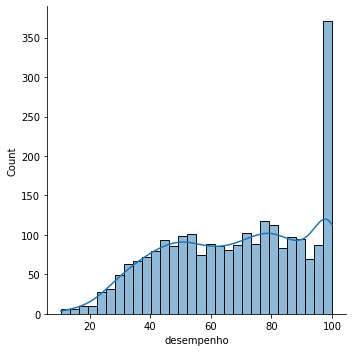

In [9]:
## Kernel density estimation (KDE) - função densidade de probabilidade da variável Target (desempenho), com histograma
import seaborn as sns
sns.displot(dados.desempenho,kde=True,bins=30)

**A maioria dos alunos tiveram nota maxima**

In [10]:
#Tabela do KDE 
dados.desempenho.value_counts().head(10)

100.000000    295
43.900002      11
90.099998      10
78.099998       9
60.799999       9
80.099998       9
53.299999       9
93.400002       9
45.299999       8
85.699997       8
Name: desempenho, dtype: int64

**Insight:**


- **Tem alguma escola especifica que faz com que os alunos tirem 100 no desempenho?**

<AxesSubplot:xlabel='desempenho', ylabel='Density'>

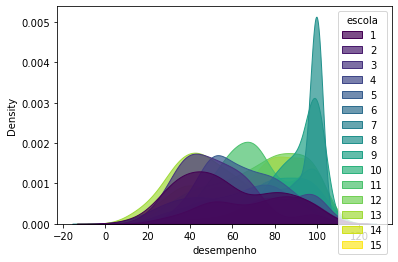

In [11]:
## Kernel density estimation (KDE) - função densidade de probabilidade da variável Target (desempenho), com histograma
sns.kdeplot(data=dados, x="desempenho", hue="escola",fill='escola',palette="viridis",alpha=.7)

**Existem algumas escola que estão elevando o desempenho dos alunos, vamos observar nos histogramas abaixo quais são essas escolas**

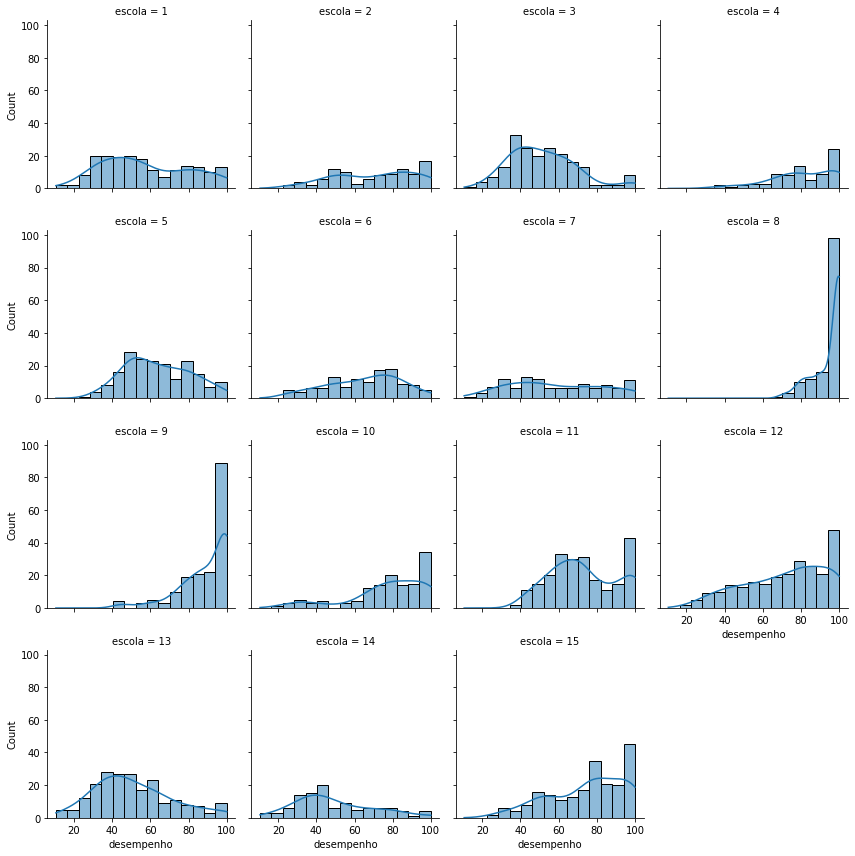

In [12]:
#Histograma individual do desempenho por escola
sns.displot(dados, x="desempenho", col="escola",kde=True,bins=15,col_wrap=4, height=3)

**As Escolas de número 8 e 9, tem um desempenho melhor nas notas dos alunos, em relação as outras escolas**

### Desempenho X Mês

Text(0, 0.5, 'Desempenho')

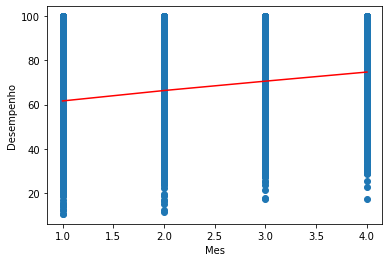

In [13]:
## Gráfico da evolução temporal média do desempenho escolar dos estudantes (ajuste linear)
media_escola= pd.DataFrame(dados.groupby('mes').desempenho.mean())
plt.scatter(dados.mes,dados.desempenho)
plt.plot(media_escola.desempenho,c='red')
plt.xlabel('Mes')
plt.ylabel('Desempenho')

**Podemos observar que a medida que os meses passam, a média do desempenho dos alunos também aumentam**

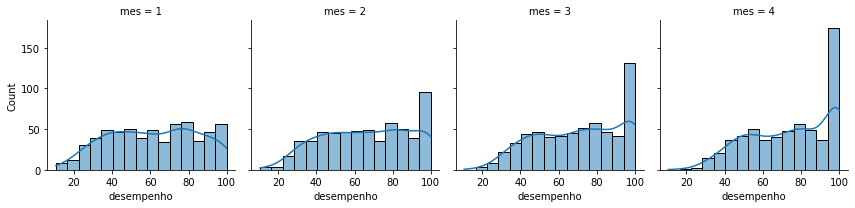

In [14]:
#Desempenho X Mês
sns.displot(dados, x="desempenho", col="mes",kde=True,bins=15,col_wrap=4, height=3)

**Podemos observar que a partir do período 2 começou aumentar o desempenho dos estudantes, porém os meses 3 e 4 foram os mais relevantes**

## Gráfico da evolução temporal do desempenho médio por escola (ajustes lineares)

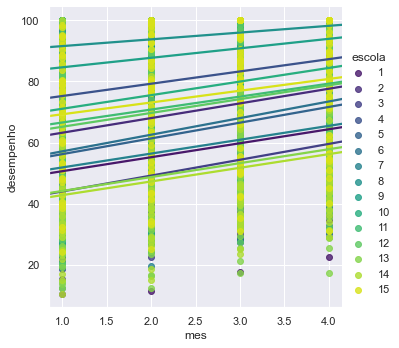

In [15]:
#Gráfico evolução temporal e ajuste linear
import seaborn as sns
sns.set_theme(color_codes=True)
ax = sns.lmplot(x="mes", y="desempenho", hue="escola", data=dados,palette='viridis',truncate=False,ci=0)

**Houve um aumento no desempenho dos alunos em todas as escolas ao longo do tempo**

# Modelagem Multinivel:

# 1° Estágio do modelo Step Up:

## ESTIMAÇÃO DO MODELO NULO HLM3 

### Objetivo: Verificar se existe diferenças entre o desempenhos dos alunos ao longo do tempo e entre alunos  da mesma escola e  escolas destintas

In [16]:
#Modelo HLM3 usando algoritimo Lmer
from pymer4.models import Lmer 
model = Lmer("desempenho ~ 1 + (1|estudante) + (1|escola)", data=dados)

display(model.fit())
model.summary;

Formula: desempenho~1+(1|estudante)+(1|escola)

Family: gaussian	 Inference: parametric

Number of observations: 2440	 Groups: {'estudante': 610.0, 'escola': 15.0}

Log-likelihood: -9092.139 	 AIC: 18184.277

Random effects:

                  Name      Var     Std
estudante  (Intercept)  325.799  18.050
escola     (Intercept)  180.189  13.423
Residual                 41.649   6.454

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),68.714,61.75,75.678,3.553,13.983,19.339,0.0,***


In [17]:
#Modelo HLM3 usando algoritimo mixedlm
import statsmodels.formula.api as smf
from patsy import dmatrices

#Parametros para definição dos niveis

# Para dizer ao modelo que uma variável é categórica, ela precisa ser 'embrulhada' em C(independent_variable)
nivel_1 = "desempenho ~ 1"
random = {"estudante": "0 + C(estudante)", "escola": "0 + C(escola)"} #nivel 2 = estudante , nivel 3 = escola
nivel_3 = dados["escola"]

#Modelo Multinivel Nulo
import statsmodels.formula.api as smf
from patsy import dmatrices

modelo1  = smf.mixedlm(nivel_1, dados, groups=nivel_3,vc_formula=random);
hlm3_nulo = modelo1.fit();
print(hlm3_nulo.summary());

          Mixed Linear Model Regression Results
Model:             MixedLM Dependent Variable: desempenho
No. Observations:  2440    Method:             REML      
No. Groups:        15      Scale:              41.6494   
Min. group size:   80      Log-Likelihood:     -9092.1387
Max. group size:   248     Converged:          Yes       
Mean group size:   162.7                                 
---------------------------------------------------------
               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------
Intercept      68.714    3.553 19.337 0.000 61.749 75.679
escola Var    180.222   11.137                           
estudante Var 325.798    3.477                           



# P-value dos parâmetros 

In [18]:
round(hlm3_nulo.pvalues,4)

Intercept        0.0000
escola Var       0.0122
estudante Var    0.0000
dtype: float64

**Os efeitos aleatórios de intercepto das variáveis 'estudante' e 'escola' ao longo do tempo são estatisticamente significantes a um nível de significância de 5%**

## Parâmetros das variáveis

In [19]:
print(f'Intercepto efeito Fixo: {round(hlm3_nulo.fe_params[0],3)}')

print(f'\nIntercepto efeito aleatório Escola: {round(hlm3_nulo.vcomp[0],3)}')

print(f'\nIntercepto efeito aleatório Estudante: {round(hlm3_nulo.vcomp[1],3)}')

Intercepto efeito Fixo: 68.714

Intercepto efeito aleatório Escola: 180.222

Intercepto efeito aleatório Estudante: 325.798


# Calculo do ICC (3 niveis)

- **ICC - Intraclass Correlation**


- **Calcula a variação explicada da variável Y em relação as variáveis X, operando em dados estruturados como grupos(Perspectiva Multinível)**


- **Proporção da variância do nível escola em relação a variância total dos termos de erro**

In [20]:
#Desempenho X Escola

#Parametros
t00k = hlm3_nulo.vcomp[0] # Efeito aleatorio de intercpto nivel escola
v0jk = hlm3_nulo.vcomp[1] # Efeito aleatorio de intercpto nivel Aluno
E = hlm3_nulo.scale # Variancia E(erro) do efeito aleatorio do nivel individuo

#Formula ICC
icc_escola = t00k /(t00k + v0jk + E)

print(f'ICC_escola= {round(icc_escola*100)}%')

ICC_escola= 33%


**33% da variação do desempenho ao longo do tempo é devido a variavel escola**

In [21]:
#Desempenho X estudante

#Parametros
t00k = hlm3_nulo.vcomp[0] # Efeito aleatorio de intercpto nivel escola
v0jk = hlm3_nulo.vcomp[1] # Efeito aleatorio de intercpto nivel Aluno
E = hlm3_nulo.scale # Variancia E(erro) do efeito aleatorio do nivel individuo

#Formula ICC
icc_aluno = v0jk /(v0jk + t00k + E)
print(f'ICC_aluno= {round(icc_aluno*100)}%')

ICC_aluno= 59%


**59% da variação do desempenho ao longo do tempo é devido a variavel 'estudante'**

In [22]:
#Desempenho X Tempo

#Parametros
total = 1 #Total do ICC
icc_escola #Porcentagem do ICC da Escola
icc_aluno  #Porcentagem do ICC do Estudante

#Formula ICC
icc_tempo = total -(icc_escola + icc_aluno)
print(f'ICC_tempo= {round(icc_tempo*100)}%')

ICC_tempo= 8%


**8% da alteração do desempenho é devido a evolução temporal**

## ESTIMAÇÃO DO MODELO NULO OLS

In [23]:
import statsmodels.api as sm
x_interc = sm.add_constant(x) # Somente o Intercept
modelo2 = sm.OLS(y,x_interc[['const']]) # funçao 
ols_nulo = modelo2.fit() # Treinar o modelo
ols_nulo.summary() # Verificar os dados do modelo

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             desempenho   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Thu, 10 Mar 2022   Prob (F-statistic):                nan
Time:                        09:45:39   Log-Likelihood:                -11110.
No. Observations:                2440   AIC:                         2.222e+04
Df Residuals:                    2439   BIC:                         2.223e+04
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         68.3414      0.465    146.892      0.000      67.429      69.254
==============================================================================
Omnibus:                      742.376   Durbin-Watson:                   0.440
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              133.934
Skew:                          -0.230   Prob(JB):                     8.25e-30
Kurtosis:                       1.949   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## COMPARAÇÃO DO HLM3 NULO COM UM OLS NULO  

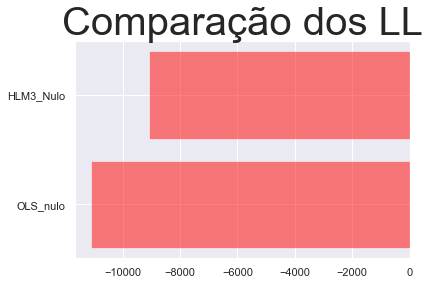

In [24]:
#Criar um dataFrame com os LLs
a = ['HLM3_Nulo','OLS_nulo']
b = [hlm3_nulo.llf,ols_nulo.llf]
dados_grafico = pd.DataFrame(a,b)
dados_grafico= dados_grafico.reset_index()
dados_grafico.columns=['Index','Modelo']

#Plotar no Grafico 
df_ordenado = dados_grafico.sort_values(by='Index',ascending=True)
plt.barh(df_ordenado.Modelo, df_ordenado.Index, color='red', alpha=0.5)
plt.title('Comparação dos LL',size=40,);

**Como os interceptos do modelo multinível foi estatisticamente significantes o LL do modelo OLS não será superior**

## 2° Estagio do modelo Step Up:




## Estimação do modelo HLM3 com tendência linear e interceptos e inclinações aleatórias

### OBS: Pulamos 1 estagio do intercepto aleatório, porém caso essa etapa não se mostre estatisticamente significante, devemos voltar para etapa anterior

### Objetivo: Verificar a significancia estatistica das escola(nivel 3) e dos alunos(nivel 2) em relaçao ao desempenho(Target) com a variável 'mes' em todos os niveis 

In [25]:
#Modelo3
hlm3_Inte_Incl = Lmer("desempenho ~ mes + (mes|estudante) + (mes|escola)", data=dados)

hlm3_Inte_Incl.fit()

hlm3_Inte_Incl.summary()

Formula: desempenho~mes+(mes|estudante)+(mes|escola)

Family: gaussian	 Inference: parametric

Number of observations: 2440	 Groups: {'estudante': 610.0, 'escola': 15.0}

Log-likelihood: -7411.506 	 AIC: 14823.013

Random effects:

                  Name      Var     Std
estudante  (Intercept)  388.982  19.723
estudante          mes    3.325   1.823
escola     (Intercept)  225.474  15.016
escola             mes    0.553   0.744
Residual                  3.795   1.948

                   IV1  IV2   Corr
estudante  (Intercept)  mes -0.414
escola     (Intercept)  mes -0.880

Fixed effects:

Formula: desempenho~mes+(mes|estudante)+(mes|escola)

Family: gaussian	 Inference: parametric

Number of observations: 2440	 Groups: {'estudante': 610.0, 'escola': 15.0}

Log-likelihood: -7411.506 	 AIC: 14823.013

Random effects:

                  Name      Var     Std
estudante  (Intercept)  388.982  19.723
estudante          mes    3.325   1.823
escola     (Intercept)  225.474  15.016
escola       

,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),57.856,50.078,65.635,3.969,13.994,14.578,0.0,***
mes,4.337,3.925,4.748,0.210,13.820,20.664,0.0,***


In [26]:
#Efeitos fixos
hlm3_Inte_Incl.coefs

,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),57.856117,50.077670,65.634564,3.968668,13.993803,14.578219,7.462237e-10,***
mes,4.336513,3.925193,4.747834,0.209861,13.819995,20.663712,8.689833e-12,***


In [27]:
#Efeitos Aleatorios
hlm3_Inte_Incl.ranef_var[:4]

,Name,Var,Std
estudante,(Intercept),388.982493,19.722639
estudante,mes,3.325111,1.823489
escola,(Intercept),225.473979,15.015791
escola,mes,0.552928,0.743591


## COMPARAÇÃO DOS LOGLIKES ENTRE OS MODELOS

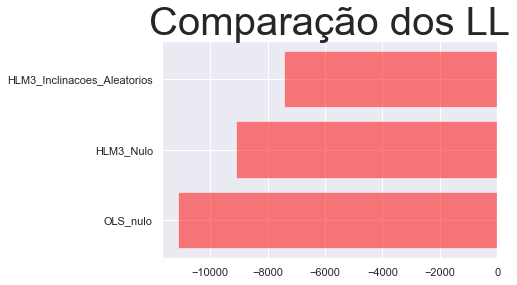

In [28]:
#Criar um dataFrame com os LLs
a = ['HLM3_Nulo','OLS_nulo','HLM3_Inclinacoes_Aleatorios']
b = [hlm3_nulo.llf,ols_nulo.llf,hlm3_Inte_Incl.logLike]
dados_grafico = pd.DataFrame(a,b)
dados_grafico= dados_grafico.reset_index()
dados_grafico.columns=['Index','Modelo']

#Plotar no Grafico 
df_ordenado = dados_grafico.sort_values(by='Index',ascending=True)
plt.barh(df_ordenado.Modelo, df_ordenado.Index, color='red', alpha=0.5)
plt.title('Comparação dos LL',size=40,);

**Como a variáveis 'mes' se mostrou estatisticamente significante, o LL do modelo foi ainda melhor que os anteriores**

## 3° Estagio do modelo Step Up:




## Estimação do modelo final HLM3 com tendência linear, Interceptos e inclinações aleatórias e as variáveis 'ativ' nivel 2 e 'texp' nivel 3

In [29]:
#Modelo 4
modelo_final = Lmer("desempenho ~ mes + ativ + texp + ativ:mes + texp:mes + (mes|estudante) + (mes|escola)", data=dados)

modelo_final.fit()

 
modelo_final.summary()

Formula: desempenho~mes+ativ+texp+ativ:mes+texp:mes+(mes|estudante)+(mes|escola)

Family: gaussian	 Inference: parametric

Number of observations: 2440	 Groups: {'estudante': 610.0, 'escola': 15.0}

Log-likelihood: -7376.715 	 AIC: 14753.429

Random effects:

                  Name      Var     Std
estudante  (Intercept)  350.912  18.733
estudante          mes    3.258   1.805
escola     (Intercept)   88.732   9.420
escola             mes    0.255   0.505
Residual                  3.795   1.948

                   IV1  IV2   Corr
estudante  (Intercept)  mes -0.392
escola     (Intercept)  mes -0.669

Fixed effects:

Formula: desempenho~mes+ativ+texp+ativ:mes+texp:mes+(mes|estudante)+(mes|escola)

Family: gaussian	 Inference: parametric

Number of observations: 2440	 Groups: {'estudante': 610.0, 'escola': 15.0}

Log-likelihood: -7376.715 	 AIC: 14753.429

Random effects:

                  Name      Var     Std
estudante  (Intercept)  350.912  18.733
estudante          mes    3.258   1.8

,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),40.032,32.455,47.609,3.866,14.193,10.355,0.000,***
mes,5.168,4.692,5.643,0.243,16.503,21.296,0.000,***
ativsim,14.702,11.183,18.221,1.796,606.764,8.188,0.000,***
texp,1.179,0.501,1.857,0.346,13.131,3.408,0.005,**
mes:ativsim,-0.652,-1.014,-0.290,0.185,514.042,-3.529,0.000,***
mes:texp,-0.057,-0.098,-0.015,0.021,13.708,-2.698,0.018,*


**Todos os p_values são estatisticamente significantes**

## COMPARAÇÃO DOS LOGLIKES ENTRE OS MODELOS

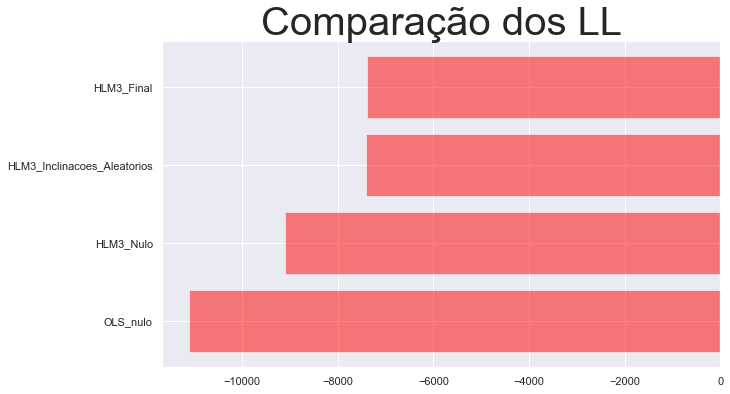

In [30]:
#Criar um dataFrame com os LLs
a = ['HLM3_Nulo','OLS_nulo','HLM3_Inclinacoes_Aleatorios','HLM3_Final']
b = [hlm3_nulo.llf,ols_nulo.llf,hlm3_Inte_Incl.logLike,modelo_final.logLike]
dados_grafico = pd.DataFrame(a,b)
dados_grafico= dados_grafico.reset_index()
dados_grafico.columns=['Index','Modelo']

#Plotar no Grafico 
plt.figure(figsize=(10, 6))
df_ordenado = dados_grafico.sort_values(by='Index',ascending=True)
plt.barh(df_ordenado.Modelo, df_ordenado.Index, color='red', alpha=0.5)
plt.title('Comparação dos LL',size=40,);


**As variáveis adicionadas 'ativ' e 'texp' se mostraram significantes para o modelo, portanto o modelo final foi o que obteve o melhor LL**

## Verificar se os LL do modelo final e do modelo HLM3_Inclinacoes_Aleatorios são estatisticamente diferentes de zero

In [31]:
#Comparação dos LL
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

def lrtest(llmin, llmax):
    lr = 2 * (llmax - llmin)
    p = stats.chisqprob(lr, 1) # llmax has 1 dof more than llmin
    return lr, p

lr, p = lrtest(hlm3_Inte_Incl.logLike,modelo_final.logLike)
print(f'P_valor: {round(p,10)}')

P_valor: 0.0


**p_value < 0.05, rejeita a hipótese nula, os loglikes dos 2 modelos não são estatisticamente iguais, portanto o modelo final apresentou o melhor LL, consequentemente o melhor modelo**

### Gráfico dos parâmetros da variavel Escola

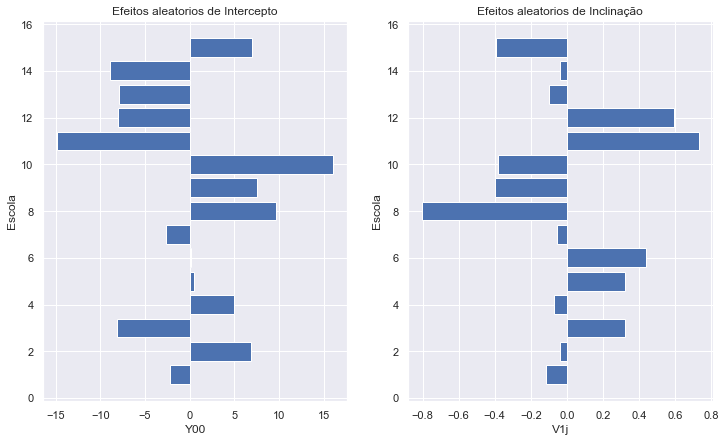

In [32]:
#Parametros Aleatório Escola
aleat_escola = modelo_final.ranef[1]
aleat_escola

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,7))
a = np.arange(len(aleat_escola))+1
b = aleat_escola.iloc[:,0]
ax1.barh(a,b);
ax1.set(title="Efeitos aleatorios de Intercepto", xlabel="Y00", ylabel="Escola")
plt.gca().invert_yaxis()


a1 = np.arange(len(aleat_escola))+1
b1 = aleat_escola.mes
ax2.barh(a1,b1);
ax2.set(title="Efeitos aleatorios de Inclinação", xlabel="V1j", ylabel="Escola")
plt.gca().invert_yaxis()

In [33]:
#Tabela dos parâmetros de intercepto e inclinação das escolas
efeitos = pd.DataFrame(aleat_escola)
efeitos.columns = ['Escola_Intercepto','Escola_Inclinacao']
efeitos

,Escola_Intercepto,Escola_Inclinacao
1,-2.182077,-0.118645
2,6.822310,-0.040977
3,-8.109680,0.319769
4,4.958260,-0.070619
5,0.486312,0.320370
6,0.191638,0.437448
7,-2.667536,-0.052800
8,9.727054,-0.802741
9,7.497835,-0.396261
10,16.113302,-0.384274


**Podemos observar que a escola 10 apresenta o maior impacto de influência positiva para o intercepto do modelo no desempenho dos alunos e a escola 11 a menor, porém quando observamos os efeitos aleatórios ao longo dos meses a escola 11 é a que tem o maior efeito positivo**

# Previsão 

In [34]:
#Previsão dos dados X  Target
previsao = pd.DataFrame(modelo_final.fits,columns=['Previsao'])
previsao['target'] = y
previsao

,Previsao,target
0,36.790914,35.400002
1,42.046005,44.400002
2,47.301096,46.400002
3,52.556186,52.400002
4,73.716993,74.900002
...,...,...
2435,99.472755,100.000000
2436,87.928477,87.599998
2437,91.749234,92.599998
2438,95.569992,94.599998


In [35]:
#Base total
modelo_final.data

,escola,estudante,mes,desempenho,ativ,texp,residuals,fits
0,1,1,1,35.400002,não,2,-1.390913,36.790914
1,1,1,2,44.400002,não,2,2.353997,42.046005
2,1,1,3,46.400002,não,2,-0.901094,47.301096
3,1,1,4,52.400002,não,2,-0.156185,52.556186
4,1,2,1,74.900002,não,2,1.183008,73.716993
...,...,...,...,...,...,...,...,...
2435,15,609,4,100.000000,sim,9,0.527245,99.472755
2436,15,610,1,87.599998,sim,9,-0.328478,87.928477
2437,15,610,2,92.599998,sim,9,0.850764,91.749234
2438,15,610,3,94.599998,sim,9,-0.969994,95.569992


**Tabela mostra as variáveis explicativas, variável target, a previsão do modelo e os resíduos gerados**

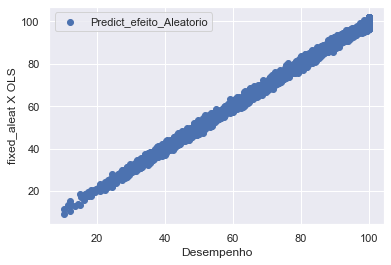

In [36]:
#Gráficos
plt.scatter(dados.desempenho,modelo_final.data.fits);

plt.xlabel('Desempenho');
plt.ylabel('fixed_aleat X OLS')
plt.legend(['Predict_efeito_Aleatorio','OLS']);

**Percebemos um ajuste linear entre os dados de desempenho(Target) em relação aos dados previstos**

## Conclusão:

**Os Modelos Multiníveis levam em consideração uma estrutura aninhada para os dados, combinando informações de variáveis de diferentes níveis, e reduzindo perda de informações, caso as variáveis se mostrem estatisticamente significantes para o modelo, dificilmente outro modelo conseguirá obter uma métrica melhor**